# Machine Learning Concepts and Principles
## Software Defect Detection

> Lazaros Panitsidis & Konstantinos Kravaritis<br />
> MSc Data Science <br />
> International Hellenic University <br />
> lpanitsidis@ihu.edu.gr & kkravaritis@ihu.edu.gr

## Contents
1. [Useful Python Libraries](#0)
1. [Data Content](#1)
1. [Feature Engineering](#2)
     1. [Data Preprocessing](#3)
     1. [Visualization & Analysis](#4)
1. [Feature Selection and Random Forest Classification](#5)
     1. [Feature Selection by Correlation](#6)
     1. [Univariate feature selection (SelectKbest)](#7)
     1. [Recursive Feature Elimination (RFE)](#8)
     1. [Recursive Feature Elimination with Cross-Validation (RFECV)](#9)
     1. [Feature importances with a forest of trees](#10)
     1. [XGBoost Feature Importances](#11)
     1. [Minimum Redundancy & Maximum Relevance](#12)
1. [Feature extraction with PCA](#11)
1. [Summary](#12)

<a id='0'></a>
## Useful Python Libraries

In [1]:
## write all the pip commands to download the packages below

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Ignore ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.utils._testing import ignore_warnings
with warnings.catch_warnings():
    # Catch and ignore ConvergenceWarnings
    warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Filter FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filter ConvergenceWarnings
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, cross_val_score , GridSearchCV , StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression # C1
from sklearn.linear_model import SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC, LinearSVC # C3 , C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, classification_report
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit


### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


### Custom Modules ###
from functions.data_types import optimize_dtypes
from functions.dataframe_actions import df_info, df_clean
from functions.ml_training import train_classifiers, train_classifiers_tuned

## Data preprocessing

### read the .csv files and make dataframes

In [3]:
# to read .csv files from another directory
data_location = "" # /<path>

jm1 = pd.read_csv(data_location + "jm1.csv")
mc1 = pd.read_csv(data_location + "mc1.csv")
pc3 = pd.read_csv(data_location + "pc3.csv")

### clean the dataframes from non-numeric data

In [4]:
# drop all rows that cointain non numeric valeus
jm1 = df_clean(jm1)
mc1 = df_clean(mc1)
pc3 = df_clean(pc3)

### extract useful information about the dataframes

In [5]:
dataframes = [jm1, mc1, pc3]
dataframe_names = ["jm1", "mc1", "pc3"]
df_info(dataframes, dataframe_names)

----- information for  jm1  -----
jm1  :  (10880, 22) (rows, columns)
jm1  :  0 missing values
jm1  :  1973 duplicated values
jm1  : Value counts for  defects
defects
False    8777
True     2103
Name: count, dtype: int64
----- information for  mc1  -----
mc1  :  (9466, 39) (rows, columns)
mc1  :  0 missing values
mc1  :  7450 duplicated values
mc1  : Value counts for  c
c
False    9398
True       68
Name: count, dtype: int64
----- information for  pc3  -----
pc3  :  (1563, 38) (rows, columns)
pc3  :  0 missing values
pc3  :  124 duplicated values
pc3  : Value counts for  c
c
False    1403
True      160
Name: count, dtype: int64


#### Label Encoding

* Use map instead of LabelEncoder() to ensure that False is 0 and True is 1 in all dataframes.
* With LabelEncoder() it depends on the order that the labels appear in the dataframe.

In [6]:
# class_le = LabelEncoder()
# jm1['defects'] = class_le.fit_transform(jm1['defects'].values)
# print("Classes of Label Encoder:", class_le.classes_)

In [7]:
# Map the "size" ordinal feature to an integer value
map_lexicon = {False: 0, True: 1}
jm1['defects'] = jm1['defects'].map(map_lexicon)
mc1['c'] = mc1['c'].map(map_lexicon)
pc3['c'] = pc3['c'].map(map_lexicon)

#### find optimal data types for faster computation

In [8]:
jm1 = optimize_dtypes(jm1)
mc1 = optimize_dtypes(mc1)
pc3 = optimize_dtypes(pc3)

In [9]:
print("---------- Optimal Data Types ----------")
print(jm1.dtypes)
print("---------- Optimal Data Types ----------")
print(mc1.dtypes)
print("---------- Optimal Data Types ----------")
print(pc3.dtypes)

---------- Optimal Data Types ----------
loc                  float16
v(g)                 float16
ev(g)                float16
iv(g)                float16
n                    float16
v                    float32
l                    float16
d                    float16
i                    float16
e                    float32
b                    float16
t                    float32
lOCode                uint16
lOComment             uint16
lOBlank               uint16
locCodeAndComment      uint8
uniq_Op              float16
uniq_Opnd            float16
total_Op             float16
total_Opnd           float16
branchCount          float16
defects                uint8
dtype: object
---------- Optimal Data Types ----------
LOC_BLANK                            uint8
BRANCH_COUNT                        uint16
CALL_PAIRS                           uint8
LOC_CODE_AND_COMMENT                 uint8
LOC_COMMENTS                         uint8
CONDITION_COUNT                     uint16
CYCLOMAT

#### Define Feature variables (inputs or predictors) and Target variables

In [10]:
jm1_y = jm1.defects
jm1_x = jm1.drop('defects',axis = 1 )

mc1_y = mc1.c
mc1_x = mc1.drop('c',axis = 1 )

pc3_y = pc3.c
pc3_x = pc3.drop('c',axis = 1 )

## ML Models

#### define the classifiers

In [11]:
lr = LogisticRegression(random_state=13)
perc = Perceptron(random_state=13)
#linear_svm = SVC(kernel='linear', cache_size=30000) # training doesnt stop
linear_svm = LinearSVC(dual="auto", random_state=13)
rbf_svm = SVC(kernel='rbf', cache_size=30000, random_state=13)
tree = DecisionTreeClassifier(random_state=13)
rf = RandomForestClassifier(random_state=13)
mlp = MLPClassifier(random_state=13)

classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

#### define the metrics

In [12]:
# Define multiple metrics
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

# time: start - end time or %timeit

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

# sum(['fit_time])

#### define the normalization methods

In [13]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

## If we use MinMaxScaler or StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
# x_scaled = (x - x.mean())/x.std()

#### define the Cross Validation folds method

In [14]:
#rng = np.random.RandomState(13) # random number generator , use it in every random state if shuffle=True for different results.Usefull to test a specific algorithm multiple times within a for loop.
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#search_cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None)

### N1: No Normalization

#### jm1

In [15]:
jm1_nn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [16]:
# convert to dataframe for easier visualization (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html)
df_jm1_nn_results = pd.DataFrame.from_dict(jm1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_nn_results['Normalization method'] = 'No normalization'
#df_jm1_nn_results

#### mc1

In [17]:
mc1_nn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter

In [18]:
# convert to dataframe for easier visualization
df_mc1_nn_results = pd.DataFrame.from_dict(mc1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_nn_results['Normalization method'] = 'No normalization'
#df_mc1_nn_results

#### pc3

In [19]:
pc3_nn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [20]:
# convert to dataframe for easier visualization
df_pc3_nn_results = pd.DataFrame.from_dict(pc3_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_nn_results['Normalization method'] = 'No normalization'
#df_pc3_nn_results

### N2: Min-Max Normalization

#### jm1

In [21]:
jm1_mmn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
# convert to dataframe for easier visualization
df_jm1_mmn_results = pd.DataFrame.from_dict(jm1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_jm1_mmn_results

#### mc1

In [23]:
mc1_mmn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, min_max_scaler)

In [24]:
# convert to dataframe for easier visualization
df_mc1_mmn_results = pd.DataFrame.from_dict(mc1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_mc1_mmn_results

#### pc3

In [25]:
pc3_mmn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-pac

In [26]:
# convert to dataframe for easier visualization
df_pc3_mmn_results = pd.DataFrame.from_dict(pc3_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_pc3_mmn_results

### N3: Feature Standardization

#### jm1

In [27]:
jm1_fs_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [28]:
# convert to dataframe for easier visualization
df_jm1_fs_results = pd.DataFrame.from_dict(jm1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_fs_results['Normalization method'] = 'Standardization'
#df_jm1_fs_results

#### mc1

In [29]:
mc1_fs_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [30]:
# convert to dataframe for easier visualization
df_mc1_fs_results = pd.DataFrame.from_dict(mc1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_fs_results['Normalization method'] = 'Standardization'
#df_mc1_fs_results

#### pc3

In [31]:
pc3_fs_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-pac

In [32]:
# convert to dataframe for easier visualization
df_pc3_fs_results = pd.DataFrame.from_dict(pc3_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_fs_results['Normalization method'] = 'Standardization'
#df_pc3_fs_results

In [33]:
# ## example without using train_classifiers function

# lr_fs_pipe = Pipeline([('std_scaler', StandardScaler()), ('lr', LogisticRegression())])

# jm1_lr_fs_scores = cross_validate(lr_fs_pipe, jm1_x, jm1_y,
#                         cv=cv, scoring=scoring,
#                         n_jobs=None, return_train_score=False)

# jm1_lr_fs_accuracy = stats.fmean(jm1_lr_fs_scores['test_Accuracy'])
# jm1_lr_fs_f1 = stats.fmean(jm1_lr_fs_scores['test_F1-score'])
# jm1_lr_fs_g_mean = stats.fmean(jm1_lr_fs_scores['test_G-Mean score'])
# jm1_lr_fs_fit_time = sum(jm1_lr_fs_scores['fit_time'])

## Results

### jm1

In [34]:
jm1_results = pd.concat([df_jm1_nn_results, df_jm1_mmn_results, df_jm1_fs_results])
jm1_results= jm1_results.round(3)
jm1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.774,0.736,0.475,1.722,No normalization
1,Perceptron,0.677,0.617,0.424,0.177,No normalization
2,LinearSVC,0.809,0.749,0.459,7.701,No normalization
3,SVC,0.807,0.725,0.405,22.491,No normalization
4,DecisionTreeClassifier,0.716,0.721,0.544,0.844,No normalization
5,RandomForestClassifier,0.792,0.757,0.508,11.798,No normalization
6,MLPClassifier,0.790,0.723,0.414,6.218,No normalization
0,LogisticRegression,0.809,0.744,0.446,0.765,Min-Max normalization
1,Perceptron,0.808,0.753,0.474,0.307,Min-Max normalization
2,LinearSVC,0.809,0.745,0.449,0.818,Min-Max normalization


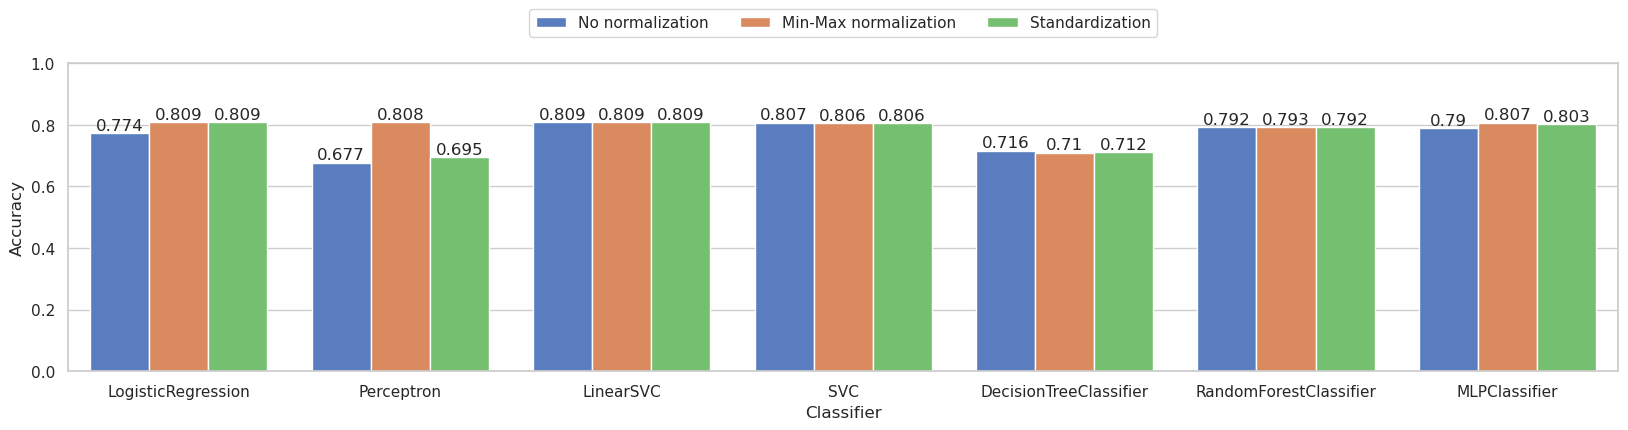

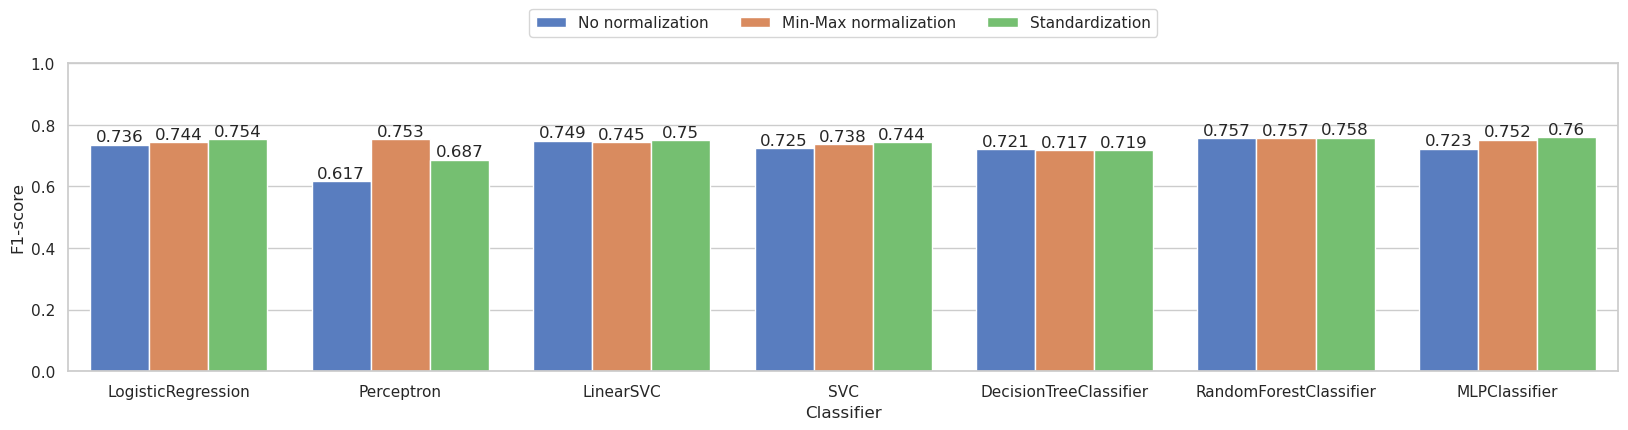

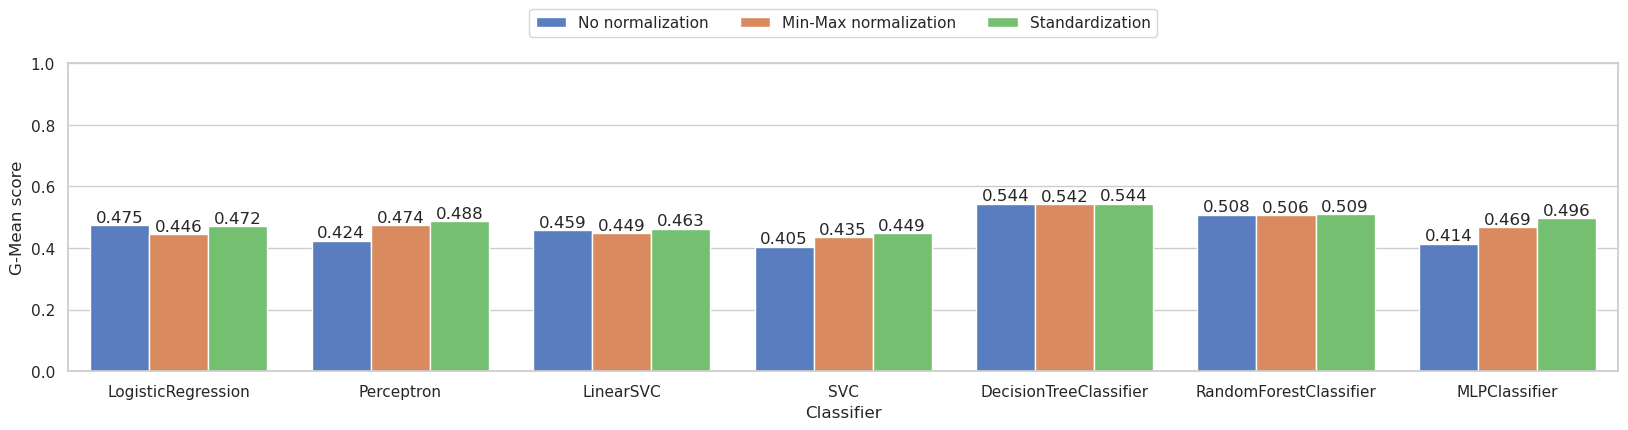

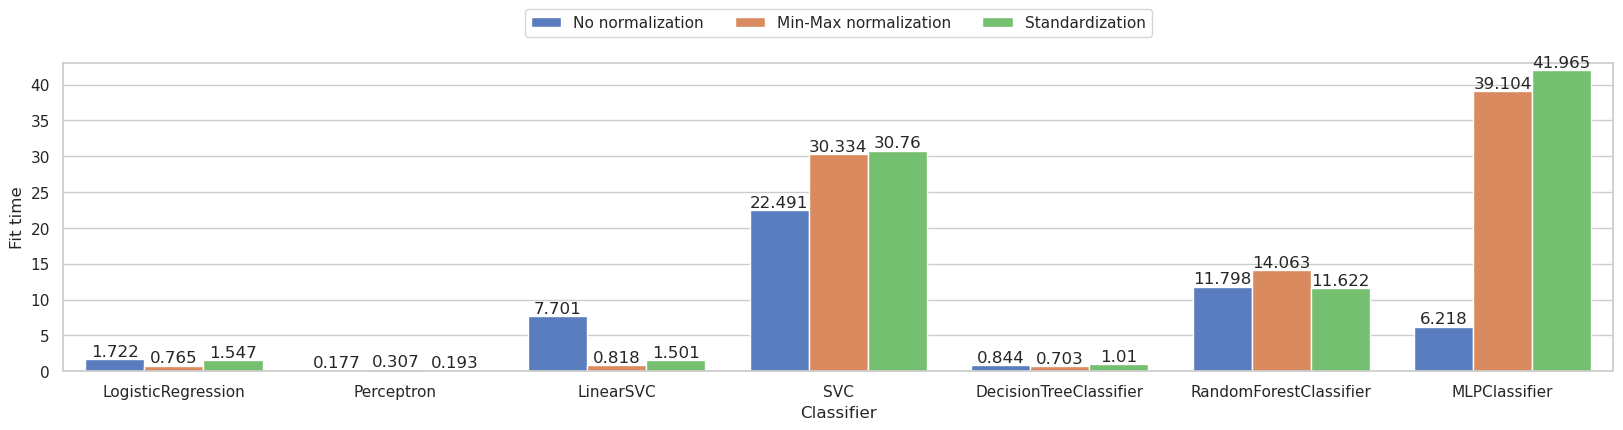

In [35]:
# set the plot style
sns.set(style="whitegrid",  palette="muted", font_scale=1)
plt.figure(figsize=(20, 4))
# Using seaborn's barplot to create a bar plot
acc = sns.barplot(data=jm1_results, x='Classifier', y='Accuracy', hue='Normalization method')
# Move the legend to the top and make it horizontal
acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
# Set y-axis limits
acc.set_ylim(0, 1)
for container in acc.containers:
    acc.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
f1 = sns.barplot(data=jm1_results, x='Classifier', y='F1-score', hue='Normalization method')
f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
f1.set_ylim(0, 1)
for container in f1.containers:
    f1.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
gmean = sns.barplot(data=jm1_results, x='Classifier', y='G-Mean score', hue='Normalization method')
gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
gmean.set_ylim(0, 1)
for container in gmean.containers:
    gmean.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
fit_time = sns.barplot(data=jm1_results, x='Classifier', y='Fit time', hue='Normalization method')
fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
fit_time.set_ylim(0, max(jm1_results['Fit time'])+1)
for container in fit_time.containers:
    fit_time.bar_label(container)
plt.show()

### mc1

In [36]:
mc1_results = pd.concat([df_mc1_nn_results, df_mc1_mmn_results, df_mc1_fs_results])
mc1_results = mc1_results.round(3)
mc1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.991,0.989,0.202,2.822,No normalization
1,Perceptron,0.963,0.974,0.082,0.212,No normalization
2,LinearSVC,0.993,0.989,0.084,11.825,No normalization
3,SVC,0.993,0.989,0.084,1.307,No normalization
4,DecisionTreeClassifier,0.993,0.993,0.733,0.294,No normalization
5,RandomForestClassifier,0.995,0.994,0.629,3.558,No normalization
6,MLPClassifier,0.993,0.989,0.084,4.494,No normalization
0,LogisticRegression,0.993,0.989,0.125,0.629,Min-Max normalization
1,Perceptron,0.968,0.976,0.215,0.234,Min-Max normalization
2,LinearSVC,0.993,0.989,0.125,0.454,Min-Max normalization


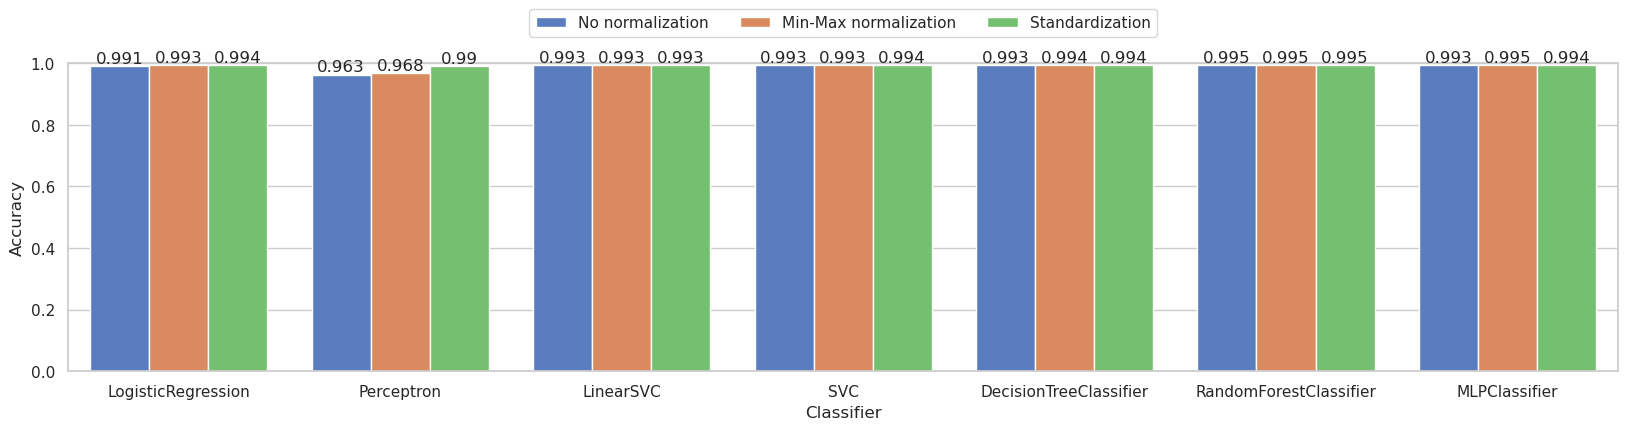

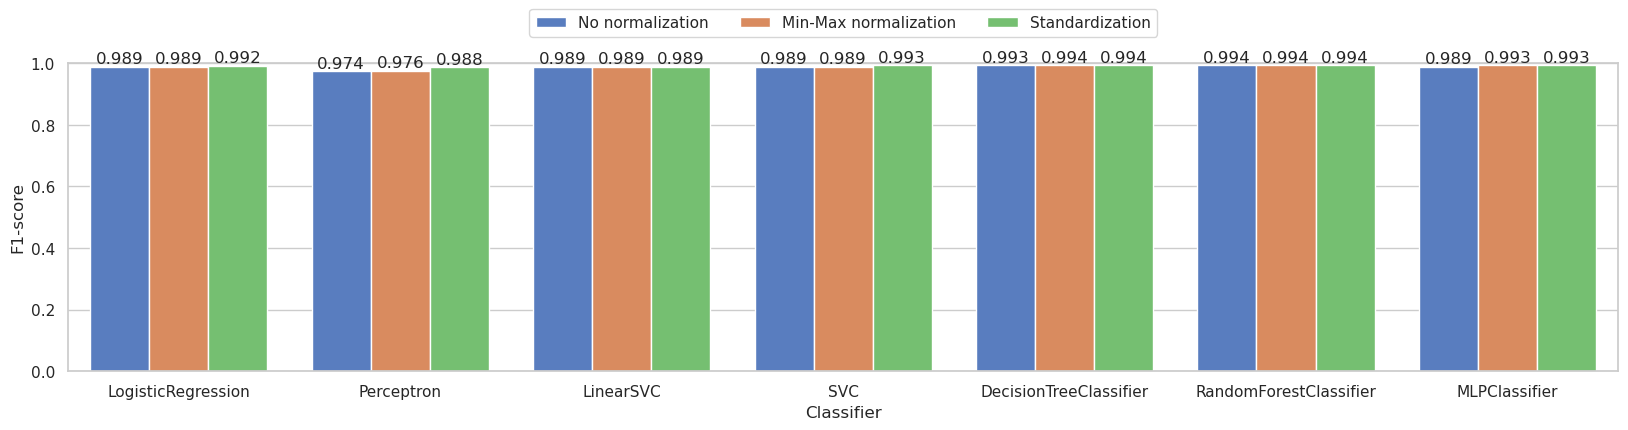

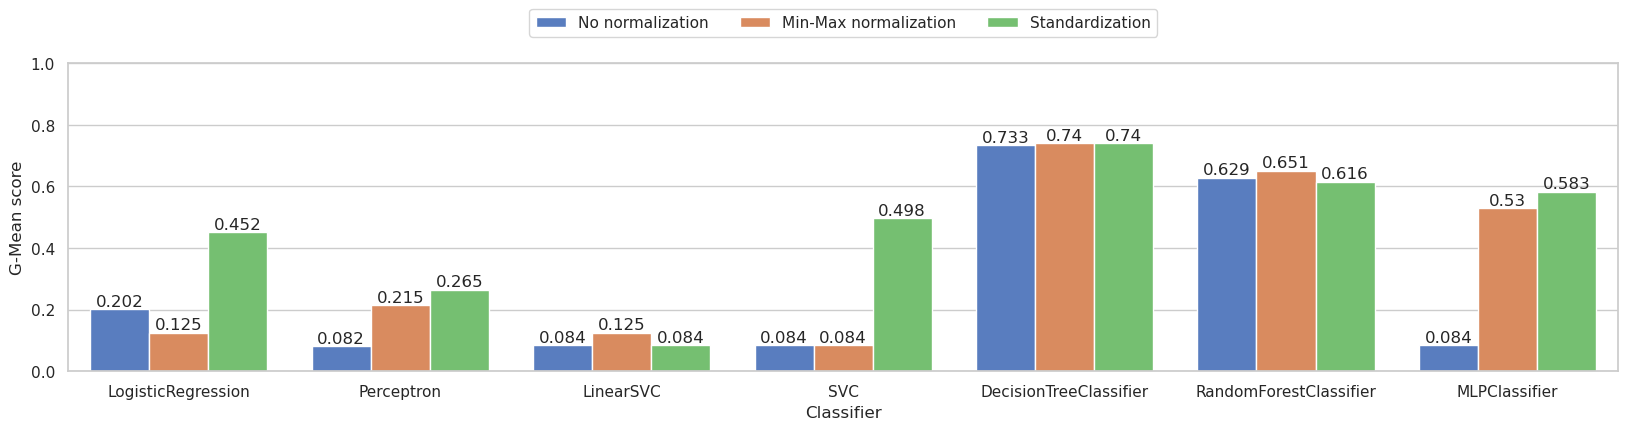

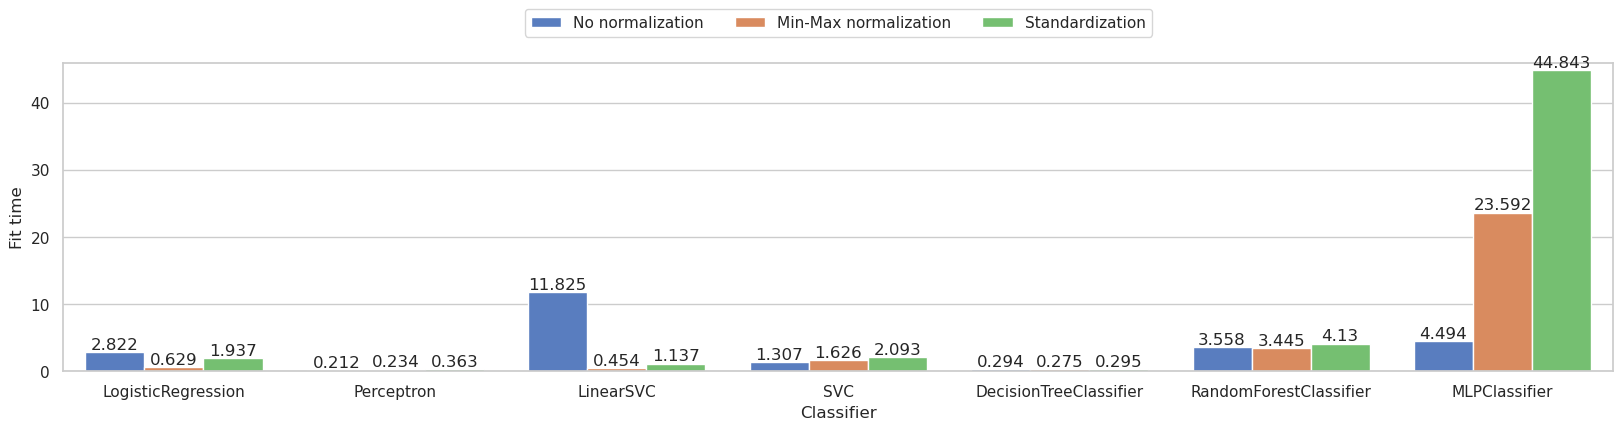

In [37]:
# set the plot style
sns.set(style="whitegrid",  palette="muted", font_scale=1)
plt.figure(figsize=(20, 4))
# Using seaborn's barplot to create a bar plot
acc = sns.barplot(data=mc1_results, x='Classifier', y='Accuracy', hue='Normalization method')
# Move the legend to the top and make it horizontal
acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
# Set y-axis limits
acc.set_ylim(0, 1)
for container in acc.containers:
    acc.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
f1 = sns.barplot(data=mc1_results, x='Classifier', y='F1-score', hue='Normalization method')
f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
f1.set_ylim(0, 1)
for container in f1.containers:
    f1.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
gmean = sns.barplot(data=mc1_results, x='Classifier', y='G-Mean score', hue='Normalization method')
gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
gmean.set_ylim(0, 1)
for container in gmean.containers:
    gmean.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
fit_time = sns.barplot(data=mc1_results, x='Classifier', y='Fit time', hue='Normalization method')
fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
fit_time.set_ylim(0, max(mc1_results['Fit time'])+1)
for container in fit_time.containers:
    fit_time.bar_label(container)
plt.show()

### pc3

In [38]:
pc3_results = pd.concat([df_pc3_nn_results, df_pc3_mmn_results, df_pc3_fs_results])
pc3_results = pc3_results.round(3)
pc3_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.900,0.874,0.465,0.302,No normalization
1,Perceptron,0.561,0.624,0.362,0.055,No normalization
2,LinearSVC,0.901,0.875,0.464,0.303,No normalization
3,SVC,0.898,0.849,0.303,0.166,No normalization
4,DecisionTreeClassifier,0.860,0.862,0.597,0.158,No normalization
5,RandomForestClassifier,0.900,0.875,0.471,2.038,No normalization
6,MLPClassifier,0.841,0.820,0.389,1.265,No normalization
0,LogisticRegression,0.898,0.857,0.354,0.114,Min-Max normalization
1,Perceptron,0.875,0.849,0.417,0.086,Min-Max normalization
2,LinearSVC,0.897,0.856,0.346,0.127,Min-Max normalization


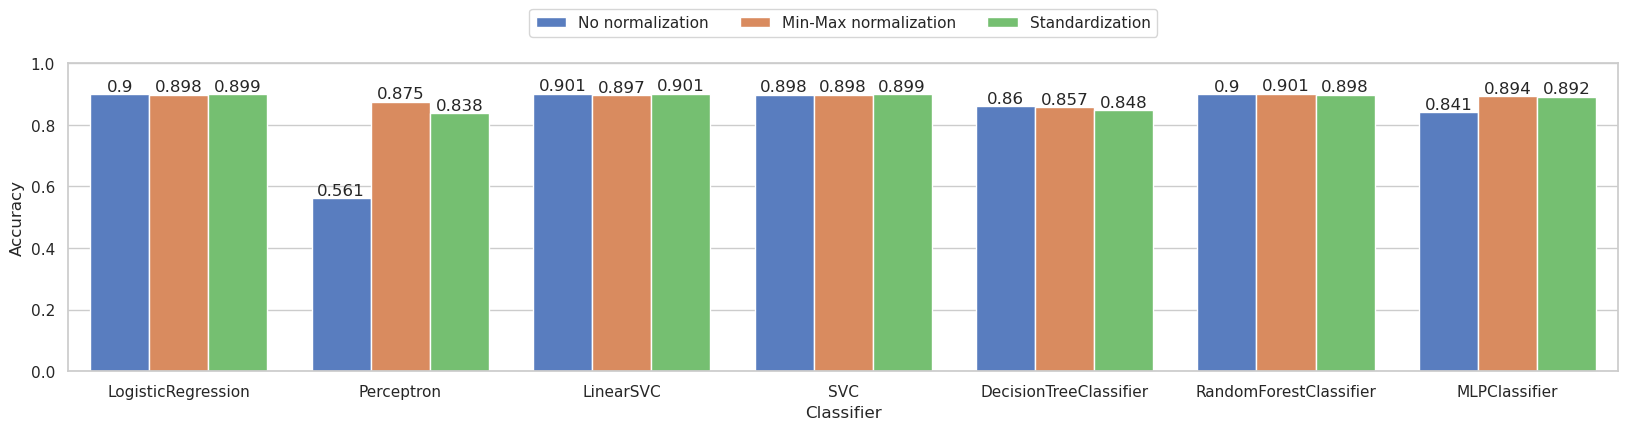

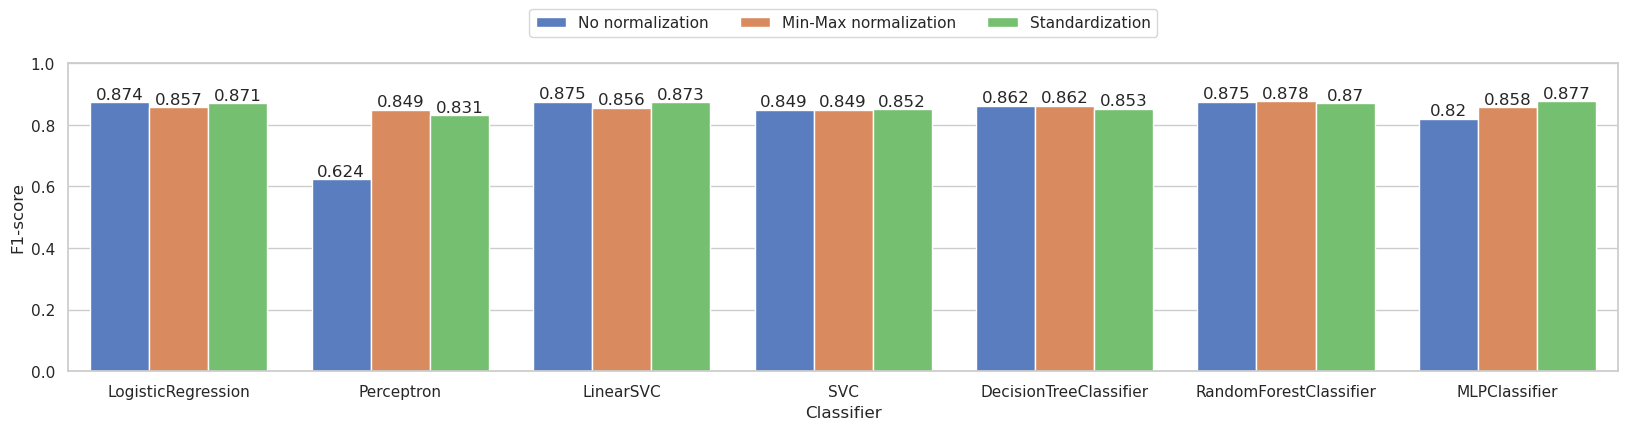

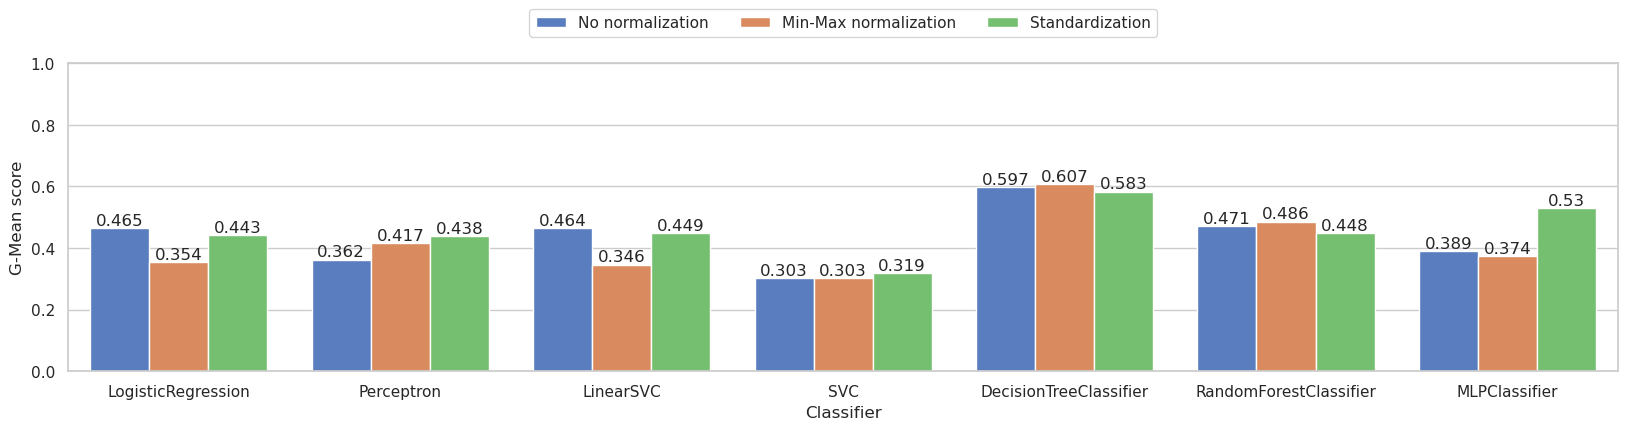

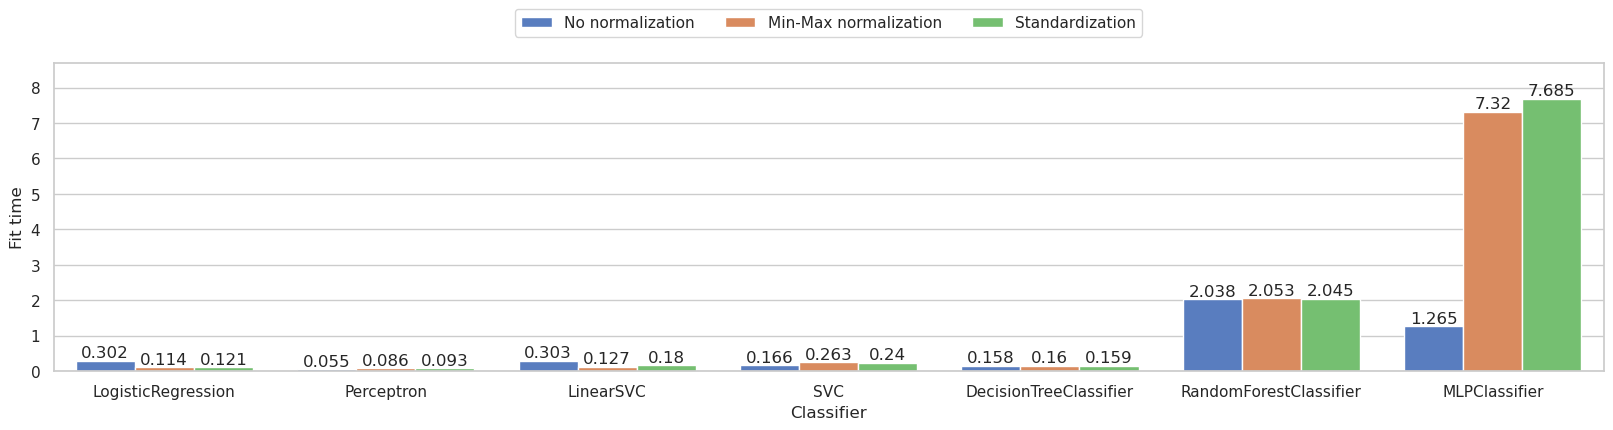

In [39]:
# set the plot style
sns.set(style="whitegrid",  palette="muted", font_scale=1)
plt.figure(figsize=(20, 4))
# Using seaborn's barplot to create a bar plot
acc = sns.barplot(data=pc3_results, x='Classifier', y='Accuracy', hue='Normalization method')
# Move the legend to the top and make it horizontal
acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
# Set y-axis limits
acc.set_ylim(0, 1)
for container in acc.containers:
    acc.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
f1 = sns.barplot(data=pc3_results, x='Classifier', y='F1-score', hue='Normalization method')
f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
f1.set_ylim(0, 1)
for container in f1.containers:
    f1.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
gmean = sns.barplot(data=pc3_results, x='Classifier', y='G-Mean score', hue='Normalization method')
gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
gmean.set_ylim(0, 1)
for container in gmean.containers:
    gmean.bar_label(container)
plt.show()

plt.figure(figsize=(20, 4))
fit_time = sns.barplot(data=pc3_results, x='Classifier', y='Fit time', hue='Normalization method')
fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
fit_time.set_ylim(0, max(pc3_results['Fit time'])+1)
for container in fit_time.containers:
    fit_time.bar_label(container)
plt.show()

# ΕΡΩΤΉΣΕΙΣ